In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#Import des données

In [25]:
data_fraud = pd.read_csv("Fraud_Data.csv")
data_IP = pd.read_csv("IpAddress_to_Country.csv")

In [26]:
data_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


#Jointure des deux bases de données

In [27]:
#On trie les bornes max des IP par ordre croissant
data_IP_sorted = data_IP.sort_values(by="upper_bound_ip_address", ascending=True)

#On crée une Series avec la borne min la plus petite, et toutes les bornes max afin d'avoir tous les intervalles possibles
bornes = pd.Series(min(data_IP_sorted.lower_bound_ip_address)).append(pd.Series(data_IP_sorted.upper_bound_ip_address),ignore_index = True)

#On associe l'index de la borne dans une nouvelle colonne pour ensuite pouvoir joindre sur ce dernier
data_fraud["index_IP"] = pd.cut(data_fraud.ip_address ,bins = bornes, labels = data_IP_sorted.country.index )

#Des NaN ont été trouvés donc on les convertis en <NA> sinon cela pose un problème lors de la jointure
data_fraud["index_IP"] = data_fraud["index_IP"].astype('float64')

df = pd.merge(data_fraud, data_IP_sorted[['country']],how ='left', left_on = "index_IP", right_index = True)
df = df.drop("index_IP", axis = 1)

In [28]:
#On constate que certaines valeurs n'ont pas trouvé de correspondance de pays
df.country.isna().value_counts()

#On les remplace par "Autres"
df["country"] = df["country"].fillna("Autre")
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Autre
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


#Analyse des données

In [29]:
#Analyse des variables quantitatives
df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


On remarque avec describe() que les données contiennent 9%  de fraudes. Etant données qu'elles sont sous représentées et que c'est ce que l'on cherche à prédire, il faudra penser à faire du resampling par exemple afin d'équilibrer le jeu de données pour entrainer le modèle

In [30]:
#On remarque que le user_id, device_id et ip_address sont uniques pour chaque ligne et n'apporteront pas d'information supplémentaire, on pourra onc les supprimer de l'analyse
print(df.user_id.unique)
print(df.device_id.unique)
print(df.ip_address.unique)
df  = df.drop(["user_id",'device_id','ip_address'	],axis=1)
df["fraud"] = df["class"]
del df['class']
df.head()

<bound method Series.unique of 0          22058
1         333320
2           1359
3         150084
4         221365
           ...  
151107    345170
151108    274471
151109    368416
151110    207709
151111    138208
Name: user_id, Length: 151112, dtype: int64>
<bound method Series.unique of 0         QVPSPJUOCKZAR
1         EOGFQPIZPYXFZ
2         YSSKYOSJHPPLJ
3         ATGTXKYKUDUQN
4         NAUITBZFJKHWW
              ...      
151107    XPSKTWGPWINLR
151108    LYSFABUCPCGBA
151109    MEQHCSJUBRBFE
151110    CMCXFGRHYSTVJ
151111    ZINIADFCLHYPG
Name: device_id, Length: 151112, dtype: object>
<bound method Series.unique of 0         7.327584e+08
1         3.503114e+08
2         2.621474e+09
3         3.840542e+09
4         4.155831e+08
              ...     
151107    3.451155e+09
151108    2.439047e+09
151109    2.748471e+09
151110    3.601175e+09
151111    4.103825e+09
Name: ip_address, Length: 151112, dtype: float64>


,signup_time,purchase_time,purchase_value,source,browser,sex,age,country,fraud
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,SEO,Chrome,M,39,Japan,0
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,Ads,Chrome,F,53,United States,0
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,SEO,Opera,M,53,United States,1
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,SEO,Safari,M,41,Autre,0
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,Ads,Safari,M,45,United States,0


Il n' y a pas de valeurs abérantes pour l'âge.

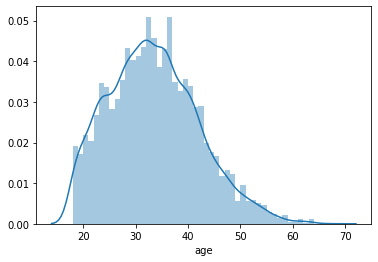

In [31]:
fraud = df[df["fraud"]==1]
sns.distplot(fraud.age)

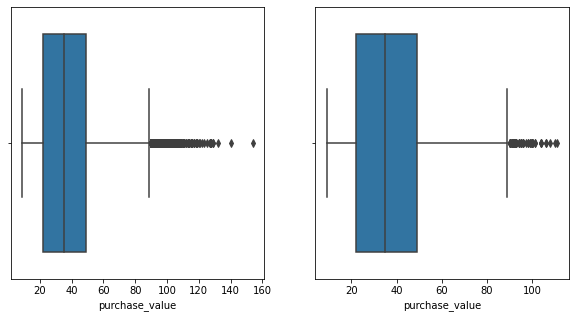

In [32]:
fig,axs = plt.subplots(ncols = 2,figsize=(10,5))
sns.boxplot(x="purchase_value", data=df, ax=axs[0])
sns.boxplot(x="purchase_value", data=fraud,ax=axs[1])
plt.show()

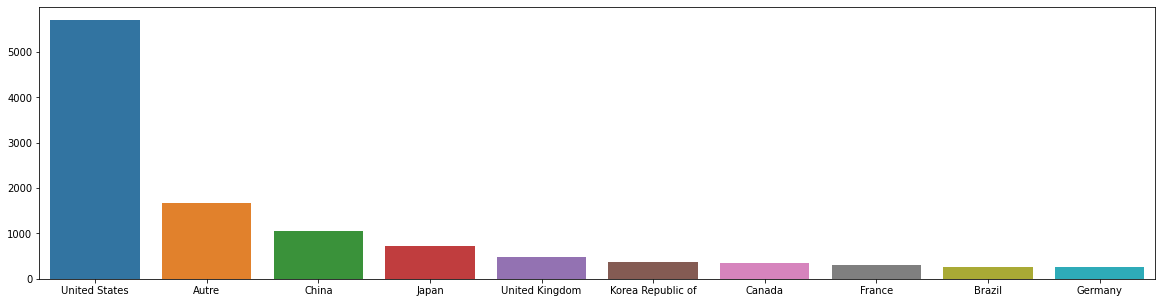

In [33]:
a = fraud.country.value_counts().head(10)
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x=a.index , y=a.values, ax = ax)

A première vue, on constate beaucoup de fraud aux Etats_Unis, et dans les pays "Autres" . Cependant, on ne peut pas tirer de conclusion trop hâtive. Il faut regarder si ces pays ne sont pas sur représentés dans le dataset. Nous allons donc nous interesser par la suite aux rapport nombre de fraud / nombre d'individus par pays.

Text(0.5, 1.0, 'Pays dont la fréqeunce de fraud est la plus élevée')

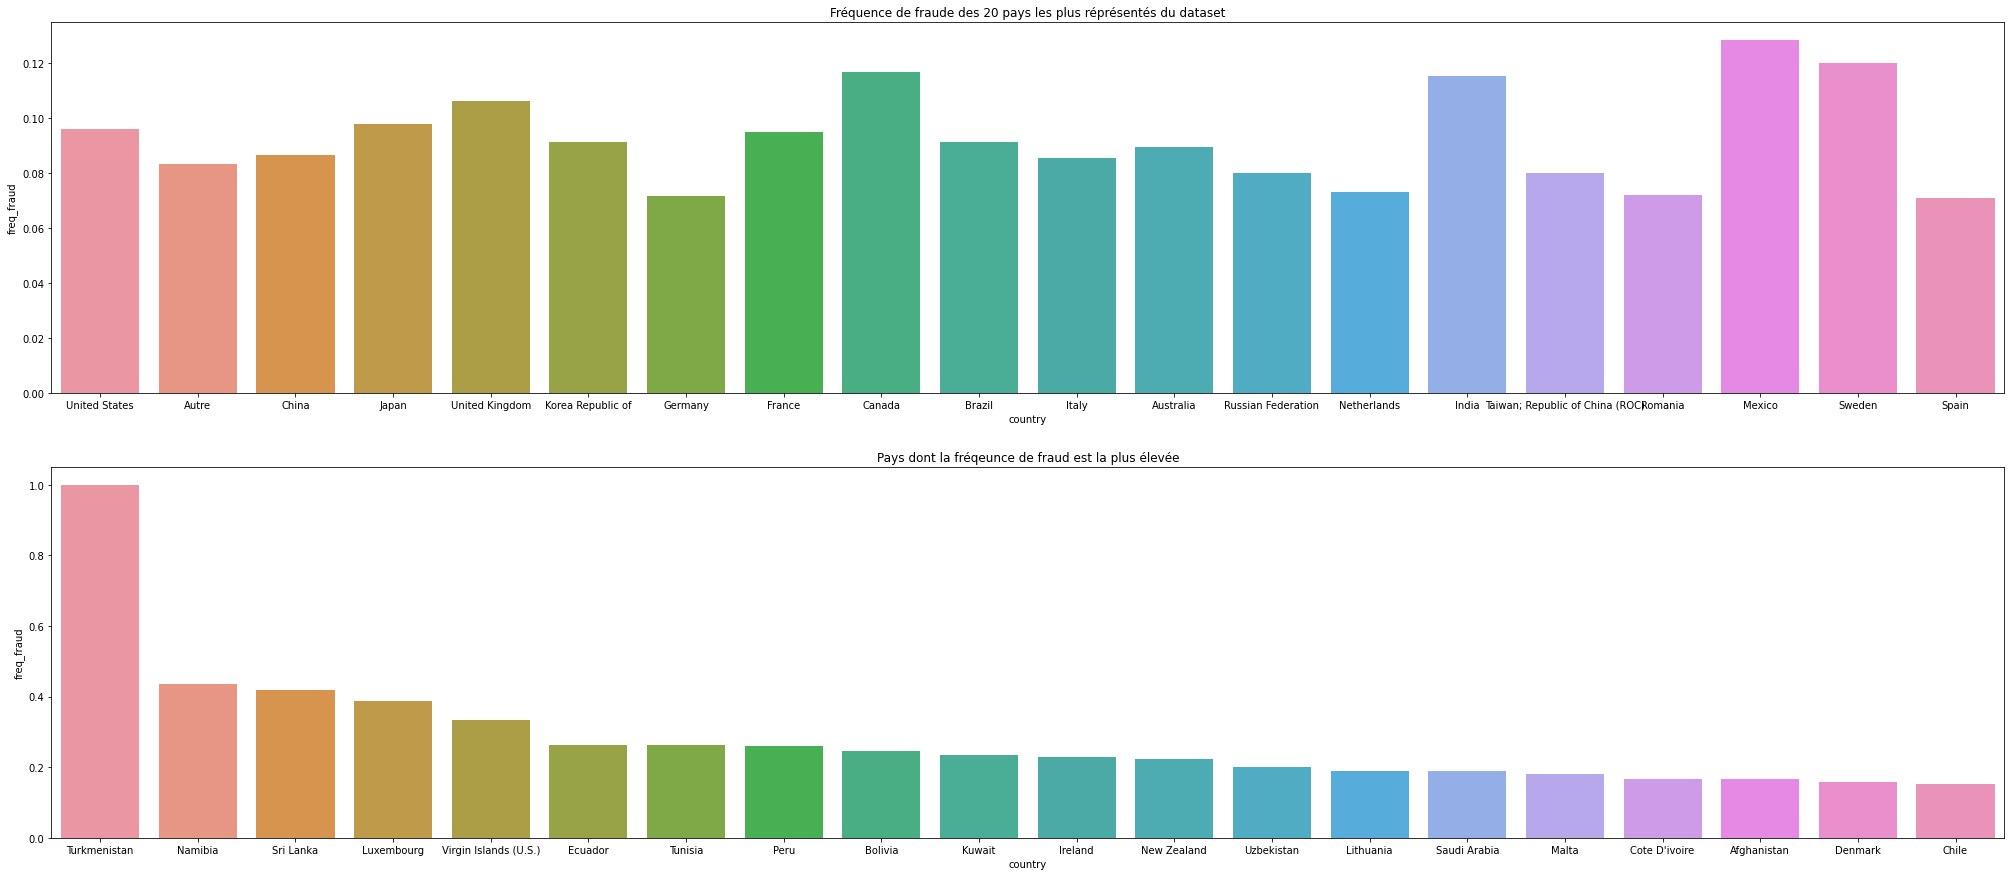

In [34]:
#Création du tableau de contingence Pays / Fraude
b = pd.crosstab(df["country"],df["fraud"])

#Calcul de la fréquence de fraude par pays
c = pd.DataFrame()
c = c.assign(freq_fraud=b[1]/(b[1]+b[0]))
c = c.assign(freq = b[1]+b[0])

#Affichage sous forme graphique de la fréquence des 20 pays les plus réprésentés et des 20 pays avec la fréqeunce de fraude la plus élevée
fig, axs = plt.subplots(2,figsize=(35,15))

a = c.sort_values(by="freq", ascending=False).head(20)
sns.barplot(x=a.index , y=a.freq_fraud, ax=axs[0])
axs[0].set_title("Fréquence de fraude des 20 pays les plus réprésentés du dataset")
b = c.sort_values(by="freq_fraud", ascending=False).head(20)
sns.barplot(x=b.index , y=b.freq_fraud, ax=axs[1])
axs[1].set_title('Pays dont la fréqeunce de fraud est la plus élevée')



Les pays avec un taux de fraude élevé ne sont pas les plus représentés. Aussi, parmi les pays les plus représentés du dataset, le taux de fraud est assez stable, avec des pays comme l'Inde, le Mexique, la Suede et le Canada qui se décroche du lot.

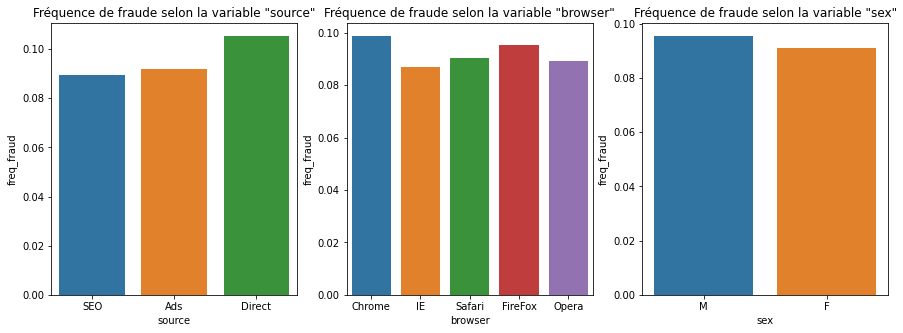

In [35]:
#Génération du même type de graphique pour les varaibles sexe browser et source
fig, axs = plt.subplots(ncols=3,figsize=(15,5))
variables = ["source","browser","sex"]
for idx, i in enumerate(variables):
  #Création du tableau de contingence Source / Fraude
  b = pd.crosstab(df[i],df["fraud"])

  #Calcul de la fréquence de fraude par source
  c = pd.DataFrame()
  c = c.assign(freq_fraud=b[1]/(b[1]+b[0]))
  c = c.assign(freq = b[1]+b[0])

  a = c.sort_values(by="freq", ascending=False)
  sns.barplot(x=a.index , y=a.freq_fraud, ax=axs[idx])
  axs[idx].set_title("Fréquence de fraude selon la variable \"{}\"".format(i))


Retraitement des valeurs temporelles

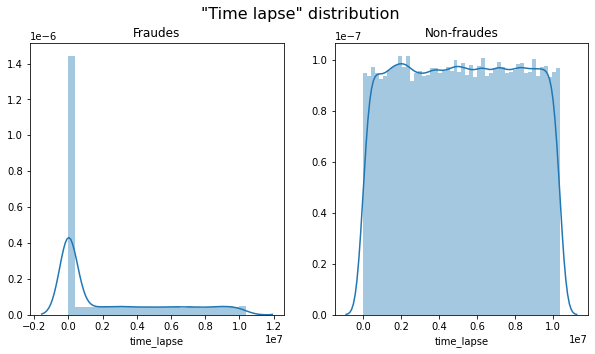

In [36]:
df["time_lapse"] = pd.to_datetime(df.purchase_time) - pd.to_datetime(df.signup_time)
df["time_lapse"] = df["time_lapse"].apply(lambda x : x.total_seconds())

fraud = df[df["fraud"]==1]
no_fraud = df[df["fraud"]==0]

fig, axs = plt.subplots(ncols=2,figsize=(10,5))
sns.distplot(fraud.time_lapse,ax=axs[0])
axs[0].set_title("Fraudes")
fig.suptitle('"Time lapse" distribution', fontsize=16)
sns.distplot(no_fraud.time_lapse,ax=axs[1])
axs[1].set_title("Non-fraudes")
plt.show()

In [37]:
#Catégorisation du datetime
df.signup_time = pd.to_datetime(df.signup_time)
df.purchase_time = pd.to_datetime(df.signup_time)

df["signup_year"] = df.signup_time.apply(lambda x : x.year)
df["signup_month"] = df.signup_time.apply(lambda x : x.month)
df["signup_day"] = df.signup_time.apply(lambda x : x.day)
df["signup_hour"] = df.signup_time.apply(lambda x : x.hour)
df["signup_minute"] = df.signup_time.apply(lambda x : x.minute)
df["signup_second"] = df.signup_time.apply(lambda x : x.second)


df["purchase_year"] = df.purchase_time.apply(lambda x : x.year)
df["purchase_month"] = df.purchase_time.apply(lambda x : x.month)
df["purchase_day"] = df.purchase_time.apply(lambda x : x.day)
df["purchase_hour"] = df.purchase_time.apply(lambda x : x.hour)
df["purchase_minute"] = df.purchase_time.apply(lambda x : x.minute)
df["purchase_second"] = df.purchase_time.apply(lambda x : x.second)

df = df.drop(['signup_time','purchase_time'], axis='columns')

In [38]:
#Dummification des variables catégoriques restantes
df = pd.get_dummies(df)

#Preprocessing

In [39]:
# On regarde la propotion de fraud dans le data set
print(df["fraud"].value_counts())

#Score sur valeur prédite à 0
print( "La proportion de fraude est de {} %".format(df["fraud"].value_counts()[0]/df["fraud"].value_counts().sum()))

0    136961
1     14151
Name: fraud, dtype: int64
La proportion de fraude est de 0.9063542273280746 %


In [40]:
df.columns

Index(['purchase_value', 'age', 'fraud', 'time_lapse', 'signup_year',
       'signup_month', 'signup_day', 'signup_hour', 'signup_minute',
       'signup_second',
       ...
       'country_United States', 'country_Uruguay', 'country_Uzbekistan',
       'country_Vanuatu', 'country_Venezuela', 'country_Viet Nam',
       'country_Virgin Islands (U.S.)', 'country_Yemen', 'country_Zambia',
       'country_Zimbabwe'],
      dtype='object', length=208)

In [41]:
X= df.loc[:, df.columns != "fraud"]
Y = df.loc[:,'fraud']
print(X.head())
print(Y.head())


#Apercu du resampling
#pd.DataFrame(y_resampled).iloc[:,0].value_counts()

   purchase_value  age  ...  country_Zambia  country_Zimbabwe
0              34   39  ...               0                 0
1              16   53  ...               0                 0
2              15   53  ...               0                 0
3              44   41  ...               0                 0
4              39   45  ...               0                 0

[5 rows x 207 columns]
0    0
1    0
2    1
3    0
4    0
Name: fraud, dtype: int64


In [42]:
#Train test plit

from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42, stratify = Y)

#Reampling 
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resample, y_train_resample = ros.fit_resample(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#Implémentation des modèles de prédiction

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

##Naive Bayes

Accuracy sur le test : 0.9063627039010026
Recall sur le test : 0.0


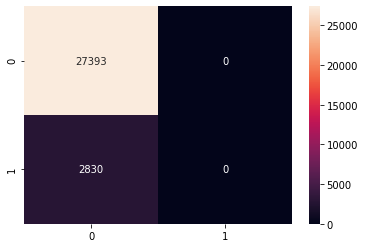

In [62]:
#Implémentation du modèle
from sklearn.preprocessing import StandardScaler  
sc_x = StandardScaler()
X_train_resample_norm = sc_x.fit_transform(X_train_resample)
X_test_norm = sc_x.transform(X_test)

from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()
nb.fit(X_train_resample_norm, y_train_resample)

#Affichage des metrics
print("Accuracy sur le test : {}".format(nb.score(X_test,y_test)))
y_pred = nb.predict(X_test)
print("Recall sur le test : {}".format(recall_score(y_test, y_pred)))

#Matrice de confusion
cm_nb = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_nb, annot=True, fmt="d")

Le modèle Naive Bayes prédit uniquement des 0 dans notre jeu de données. Malgré une accuracy élevée, il n'est donc pas pertinent pour détecter les fraudes. En enffet, comme il prédit uniquement des 0 et que notre dataset contient majoriatirement des 0, la métrique accuracy est relativement proche de 1. Il ne faut cependant pas s'arrêter à celle-ci pour évaluer le modèle. Le recall qui évalut le taux de "vrais positifs" est par conséquent ici nul, puisuqe le modèle ne prédit aucune fraude.

##Arbre de décision

Accuracy sur le test : 0.9121529960626014
Recall sur le test : 0.5643109540636042


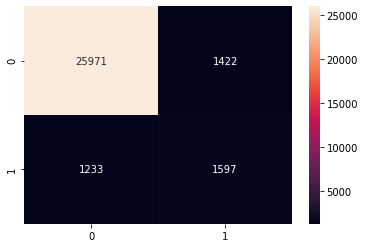

In [44]:
#Implémentation du modèle
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train_resample, y_train_resample)

#Affichage des metrics
print("Accuracy sur le test : {}".format(classifier.score(X_test,y_test)))
y_pred = classifier.predict(X_test)
print("Recall sur le test : {}".format(recall_score(y_test, y_pred)))

#Matrice de confusion
cm_classifier = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_classifier, annot=True, fmt="d")


# Plot confusion matrix

#disp = plot_confusion_matrix(classifier, X_test, y_test,
      #                           cmap=plt.cm.Blues,
       #                      values_format = '.0f')
#disp.ax_.set_title("Decision Tree Confusion Matrix")

#plt.show()

##Random Forest

Score sur le test : 0.9556959931178242
Recall sur le test : 0.5268551236749116


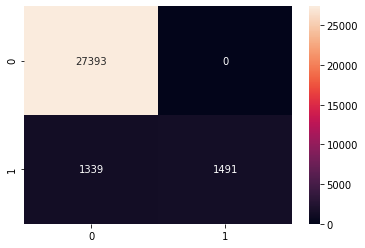

In [45]:
#Implémentation du modèle
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(random_state = 42)
random_forest.fit(X_train_resample, y_train_resample)

#Affichage des metrics
print("Score sur le test : {}".format(random_forest.score(X_test,y_test)))
y_pred = random_forest.predict(X_test)
print("Recall sur le test : {}".format(recall_score(y_test, y_pred)))

#Matrice de confusion
cm_random_forest = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_random_forest, annot=True, fmt="d")

##Boosting
###AdaBoost

Score sur le test : 0.9132117923435794
Recall sur le test : 0.5614840989399293


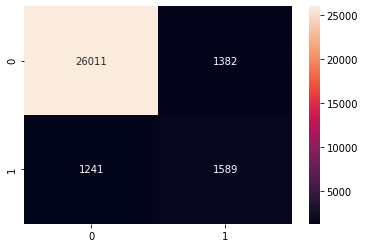

In [46]:
#Implémentation du modèle
from sklearn.ensemble import AdaBoostClassifier
adaBoost = AdaBoostClassifier(DecisionTreeClassifier(),random_state = 42)
adaBoost.fit(X_train_resample,y_train_resample)

#Affichage des metrics
print("Score sur le test : {}".format(adaBoost.score(X_test,y_test)))
y_pred = adaBoost.predict(X_test)
print("Recall sur le test : {}".format(recall_score(y_test, y_pred)))

#Matrice de confusion
cm_adaBoost = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_adaBoost, annot=True, fmt="d")

###XG Boost

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score sur le test : 0.955398206663799
Recall sur le test : 0.5268551236749116


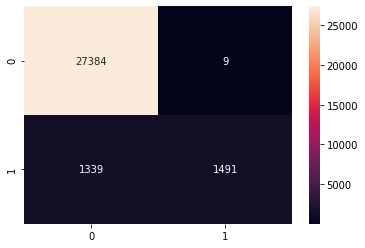

In [57]:
#Implémentation du modèle
X_train_resample_XG = pd.DataFrame(X_train_resample, columns = X_train.columns)
X_train_resample_XG.head()
y_train_resample_XG = pd.DataFrame(y_train_resample, columns=["fraud"])
y_train_resample_XG

from xgboost import XGBClassifier
xgBoost = XGBClassifier(random_state = 42)
xgBoost.fit(X_train_resample_XG,y_train_resample_XG)
xgBoost.score(X_test, y_test)

#Affichage des metrics
print("Score sur le test : {}".format(xgBoost.score(X_test,y_test)))
y_pred = xgBoost.predict(X_test)
print("Recall sur le test : {}".format(recall_score(y_test, y_pred)))

#Matrice de confusion
cm_xgBoost =  confusion_matrix(y_test, y_pred)
sns.heatmap(cm_xgBoost, annot=True, fmt="d")

#Résultats & Analyse
##Comparaison des modèles testés

In [63]:
resultats = pd.DataFrame({"modèle": ("Naive Bayes","Decision Tree", "Random Forest"," AdaBoost","XGBoost"), "Scores" : (nb.score(X_test,y_test),classifier.score(X_test,y_test),random_forest.score(X_test,y_test),adaBoost.score(X_test,y_test),xgBoost.score(X_test,y_test)),"Recall" : (recall_score(y_test,nb.predict(X_test)),recall_score(y_test,classifier.predict(X_test)), recall_score(y_test,random_forest.predict(X_test)),recall_score(y_test,adaBoost.predict(X_test)),recall_score(y_test,xgBoost.predict(X_test)))})

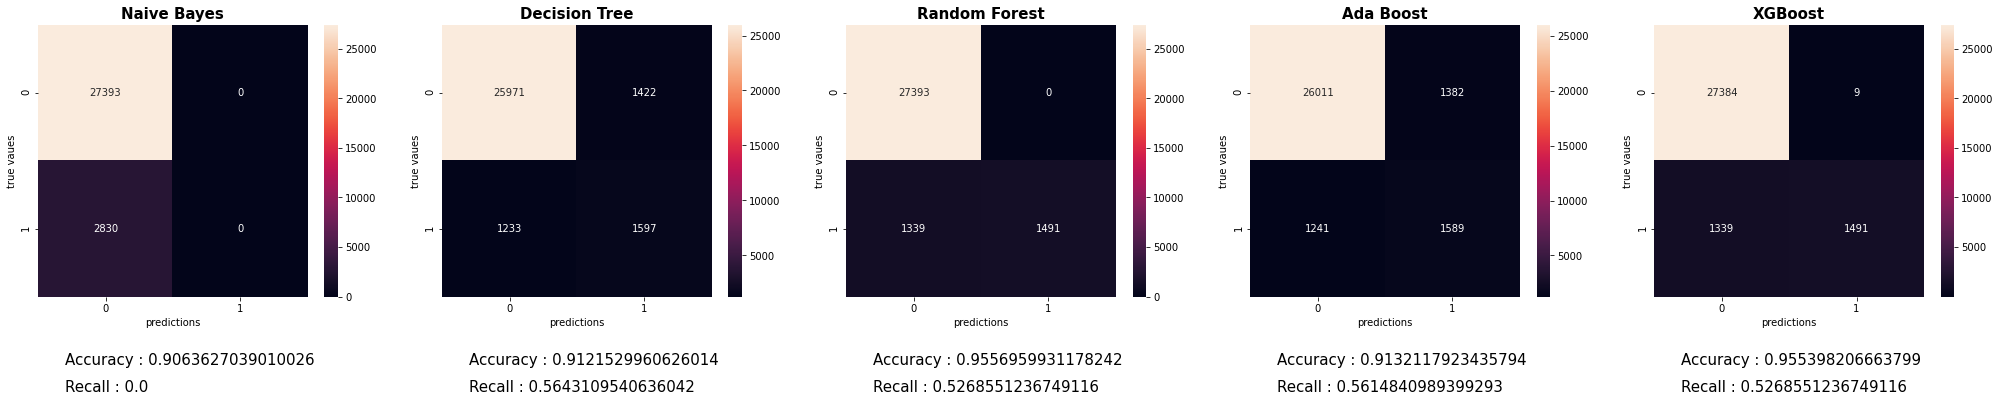

In [69]:
figure = plt.figure(figsize=(35,5))
axes = figure.add_subplot( 1, 5, 1)
sns.heatmap(cm_nb, annot=True, fmt="d")
plt.title("Naive Bayes",fontsize = 15,fontweight = 'bold')
plt.xlabel("predictions")
plt.ylabel("true vaues")
plt.text(0.2,2.5,'Accuracy : {} '.format(resultats.Scores[0]),fontsize = 15)
plt.text(0.2,2.7,'Recall : {} '.format(resultats.Recall[0]),fontsize = 15)

axes = figure.add_subplot( 1, 5, 2)
sns.heatmap(cm_classifier, annot=True, fmt="d")
plt.xlabel("predictions")
plt.ylabel("true vaues")
plt.title("Decision Tree",fontsize = 15,fontweight = 'bold')
plt.text(0.2,2.5,'Accuracy : {} '.format(resultats.Scores[1]),fontsize = 15)
plt.text(0.2,2.7,'Recall : {} '.format(resultats.Recall[1]),fontsize = 15)

axes = figure.add_subplot( 1, 5, 3)
sns.heatmap(cm_random_forest, annot=True, fmt="d")
plt.title("Random Forest",fontsize = 15,fontweight = 'bold')
plt.xlabel("predictions")
plt.ylabel("true vaues")
plt.text(0.2,2.5,'Accuracy : {} '.format(resultats.Scores[2]),fontsize = 15)
plt.text(0.2,2.7,'Recall : {} '.format(resultats.Recall[2]),fontsize = 15)

axes = figure.add_subplot( 1, 5, 4)
sns.heatmap(cm_adaBoost, annot=True, fmt="d")
plt.title("Ada Boost",fontsize = 15,fontweight = 'bold')
plt.xlabel("predictions")
plt.ylabel("true vaues")
plt.text(0.2,2.5,'Accuracy : {} '.format(resultats.Scores[3]),fontsize = 15)
plt.text(0.2,2.7,'Recall : {} '.format(resultats.Recall[3]),fontsize = 15)

axes = figure.add_subplot( 1, 5, 5)
sns.heatmap(cm_xgBoost, annot=True, fmt="d")
plt.title("XGBoost",fontsize = 15,fontweight = 'bold')
plt.xlabel("predictions")
plt.ylabel("true vaues")
plt.text(0.2,2.5,'Accuracy : {} '.format(resultats.Scores[4]),fontsize = 15)
plt.text(0.2,2.7,'Recall : {} '.format(resultats.Recall[4]),fontsize = 15)
plt.show()

Le modèle Random forest est celui qui obtient la plus grande accuracy. Cependant, comme évoqué plus haut, cette métrique n'est pas la plus pertinente pour mesurer la performance de notre modèle. Notre but est de maximiser la détection des fraudes, i.e de minimiser les "faux négatifs". Nous aimerions également minimiser les "faux positifs", c'est a dire les personnes qui n'ont pas fraudé mais qui en ont été "accusé". Nous accorderont cependant plus d'importance aux "faux négatifs", par choix. Nous préferons ne pas manquer une fraude, malgré le risque plus iportant d'accuser quelqu'un à tord. 

Le modèle qui obtient le recall le plus significatif est le decision tree. Il prédit plus de 56% des fraudes. 

##Analyse

Maintenant nous allons essayer de déterminer les facteurs qui influencent le plus la détection de fraude.

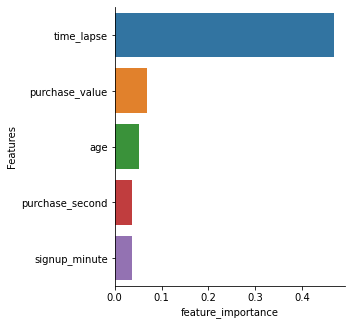

In [89]:
# Coefficient du modèle Decision Tree
coeff = pd.DataFrame(data=classifier.feature_importances_.T, columns=["feature_importance"],index = X.columns)
coeff_head = coeff.sort_values(by="feature_importance",ascending=False).head(5)
sns.catplot(data=coeff_head, y=[index for index in coeff_head.index],x="feature_importance", kind="bar")
plt.ylabel("Features")
plt.show()

On remarque grâce à l'affichage des champs les plus importants dans le modèle, que le time lapse a beaucoup d'importance dans la prédiction comparé aux autres champs. En effet on peut supposer que lors d'une fraude, l'opération est réalisée par des "robots" et ainsi le temps entre l'inscription et l'achat est relativement faible. Ainsi ce critère permet en grande partie de détecter les fraudes. 